<a href="https://colab.research.google.com/github/Jeongyeon-Myeong/Python-Project/blob/master/BERT_%EC%98%81%EC%96%B4_friends_%EB%8D%B0%EC%9D%B4%ED%84%B0_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparation**

- Edit > Notebook settings > Hardward accelerators > GPU > SAVE
- Download the Friends dataset in EmotionLines website:
http://doraemon.iis.sinica.edu.tw/emotionlines/download.html


# **Model**

##### **Settings**

In [1]:
!pip install transformers --quiet # package installer for python

     |████████████████████████████████| 1.5MB 10.5MB/s 
     |████████████████████████████████| 2.9MB 26.4MB/s 
     |████████████████████████████████| 890kB 52.3MB/s 


In [2]:
import torch
from transformers import BertModel, BertTokenizer

In [3]:
pretrained_weights = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights) #bert tokenizer
model = BertModel.from_pretrained(pretrained_weights) # bert model

**Tokenization(Example)**

In [ ]:
#예시 문장
sentence = 'My duties?  All right. '

In [ ]:
 #bert tokenizer로 토큰화
tokens = tokenizer.tokenize(sentence) #['[CLS]', 'all', 'the', 'classes', 'are', 'provided', '.', '[SEP]']
tokens = ['[CLS]'] + tokens + ['[SEP]']
print(tokens)

['[CLS]', 'my', 'duties', '?', 'all', 'right', '.', '[SEP]']


In [ ]:
# token하여 id로 바꾼다.[[101, 2035, 1996, 4280, 2024, 3024, 1012, 102]]
#Converts a token string (or a sequence of tokens) in a single integer id (or a sequence of ids), using the vocabulary.
ids = [tokenizer.convert_tokens_to_ids(tokens)]
print(ids)

[[101, 2026, 5704, 1029, 2035, 2157, 1012, 102]]


In [ ]:
ids = [[101, 2928, 1010, 2035, 1996, 4280, 2024, 3024, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
attention_masks = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
#tensor로 변경, tensor([[ 101, 2035, 1996, 4280, 2024, 3024, 1012,  102]])
input_tensor = torch.tensor(ids)
masks_tensor = torch.tensor(attention_masks)

In [ ]:
print(masks_tensor.size())

torch.Size([1, 19])


##### **Model(Example)**

In [ ]:
# id값을 bert모델에 넣기
hidden_tensor = model(input_tensor, attention_mask = masks_tensor)[0]
print(hidden_tensor.size())

torch.Size([1, 19, 768])


In [ ]:
hidden_tensor

tensor([[[-0.3332,  0.3654,  0.1161,  ..., -0.1596,  0.2420,  0.5352],
         [ 0.5816,  0.3318,  0.3934,  ...,  0.2164,  0.3406, -0.2485],
         [-0.0190,  0.4895,  0.4740,  ..., -0.3352,  0.3113,  0.3196],
         ...,
         [ 0.1850,  0.4164,  0.4646,  ...,  0.0479, -0.0294, -0.1171],
         [ 0.3209,  0.3451,  0.4535,  ...,  0.0429, -0.0533, -0.0560],
         [ 0.3667,  0.3243,  0.4432,  ...,  0.0751, -0.0630, -0.0889]]],
       grad_fn=<NativeLayerNormBackward>)

In [ ]:
#torch.Size([1, 8, 768])
logit = torch.nn.Linear(768, 2)(hidden_tensor)

In [ ]:
prediction = torch.nn.Softmax(dim=-1)(logit)

# **Emotion Recognition**

**Train and Dev Dataset**

In [4]:
# 데이터 셋 로드
import json

data = {'train': {'speaker': [], 'utterance': [], 'emotion': []},
        'dev': {'speaker': [], 'utterance': [], 'emotion': []},
        'test': {'speaker': [], 'utterance': [], 'emotion': []}}

for dtype in ['train', 'dev', 'test']:
  for dialog in json.loads(open('friends_' + dtype + '.json').read()):
    for line in dialog:
      data[dtype]['speaker'].append(line['speaker'])
      data[dtype]['utterance'].append(line['utterance'])
      data[dtype]['emotion'].append(line['emotion'])

In [5]:
# index 고정 시킨다
i2e_dict = {'joy':0,
 'surprise':1,
 'non-neutral':2,
 'sadness':3,
 'disgust':4,
 'fear':5,
 'anger':6,
 'neutral':7}

In [6]:
# dictionary 변경
i2e_dict_change = {0: 'joy',
1:'surprise',
2:'non-neutral',
3:'sadness',
4:'disgust',
5:'fear',
6:'anger',
7:'neutral'}

In [7]:
# train weight 
weights1 = [data['train']['emotion'].count('joy'),
          data['train']['emotion'].count('surprise'),
          data['train']['emotion'].count('non-neutral'),
          data['train']['emotion'].count('sadness'),
          data['train']['emotion'].count('disgust'),
          data['train']['emotion'].count('fear'),
          data['train']['emotion'].count('anger'),
          data['train']['emotion'].count('neutral')]
print(weights1) # [1283, 1220, 2017, 351, 240, 185, 513, 4752]

[1283, 1220, 2017, 351, 240, 185, 513, 4752]


In [8]:
# dev weight 
weights2 = [data['dev']['emotion'].count('joy'),
          data['dev']['emotion'].count('surprise'),
          data['dev']['emotion'].count('non-neutral'),
          data['dev']['emotion'].count('sadness'),
          data['dev']['emotion'].count('disgust'),
          data['dev']['emotion'].count('fear'),
          data['dev']['emotion'].count('anger'),
          data['dev']['emotion'].count('neutral')]
print(weights2) #[123, 151, 214, 62, 23, 29, 85, 491]

[123, 151, 214, 62, 23, 29, 85, 491]


In [9]:
# train weight dev weight의 합 
weights = [x+y for x,y in zip(weights1, weights2)] #[1406, 1371, 2231, 413, 263, 214, 598, 5243]

In [10]:
# 최종 weight 구하기
weights = [ max(weights) /num for num in weights]
print(weights) # [3.7290184921763867, 3.824215900802334, 2.350067234424025, 12.694915254237289, 19.935361216730037, 24.5, 8.767558528428093, 1.0]

[3.7290184921763867, 3.824215900802334, 2.350067234424025, 12.694915254237289, 19.935361216730037, 24.5, 8.767558528428093, 1.0]


In [11]:
# train/ dev/ test 셋으로 나눔
import pandas as pd
friendsdata_train_dict = data['train']
friendsdata_dev_dict = data['dev']
friendsdata_test_dict = data['test']

friends_traindata = pd.DataFrame(friendsdata_train_dict)
friends_devdata = pd.DataFrame(friendsdata_dev_dict)
friends_testdata = pd.DataFrame(friendsdata_test_dict)

In [12]:
# 테스트 데이터 셋은 과제에서 주어질 예정이므로 train, dev은 train으로 test 데이터는 dev로 이용
friends_traindata = pd.concat([friends_traindata, friends_devdata], join='inner') # intersection
friends_devdata = friends_testdata.copy()

In [13]:
# dataframe을 list형태로 변경함.
train_utterance = friends_traindata['utterance'].values.tolist()
dev_utterance = friends_devdata['utterance'].values.tolist()
train_emotion = friends_traindata['emotion'].values.tolist()
dev_emotion = friends_devdata['emotion'].values.tolist()
train_speaker = friends_traindata['speaker'].values.tolist()
dev_speaker = friends_devdata['speaker'].values.tolist()

In [14]:
# data copy
train_utterance_copy = train_utterance.copy()
dev_utterance_copy = dev_utterance.copy()

In [15]:
#case1 (종합 : 문맥 정보와 화자 정보를 반영)
#train_utterance
#train_speaker
def token_input(utterance, utterance_copy, speaker ):
  for i in range(len(utterance)):
    if ( i > 0 and speaker[i-1] == speaker[i]):
      utterance[i] = '[CLS] ' + speaker[i] + ', ' + utterance_copy[i] + ' [SEP] ' + utterance_copy[i-1] + ' [SEP] [PAD]' 
    elif ( i > 1 and speaker[i-2] == speaker[i] and speaker[i-1] != speaker[i]):
      utterance[i] = '[CLS] ' + speaker[i] + ', ' + utterance_copy[i] + ' [SEP] ' + utterance_copy[i-2] + ' [SEP] [PAD]' 
    else:
      utterance[i] = '[CLS] ' + speaker[i] + ', ' + utterance_copy[i] + ' [SEP] [PAD]' 

In [ ]:
#case2 (문맥 정보만 반영)
#train_utterance
#train_speaker
def token_input(utterance, utterance_copy, speaker ):
  for i in range(len(utterance)):
    if ( i > 0 and speaker[i-1] == speaker[i]):
      utterance[i] = '[CLS] ' + utterance_copy[i] + ' [SEP] ' + utterance_copy[i-1] + ' [SEP] [PAD]' 
    elif ( i > 1 and speaker[i-2] == speaker[i] and speaker[i-1] != speaker[i]):
      utterance[i] = '[CLS] ' + utterance_copy[i] + ' [SEP] ' + utterance_copy[i-2] + ' [SEP] [PAD]' 
    else:
      utterance[i] = '[CLS] ' + utterance_copy[i] + ' [SEP] [PAD]' 

In [ ]:
#case3  (화자 정보만 반영)
#train_utterance
#train_speaker
def token_input(utterance, utterance_copy, speaker ):
  for i in range(len(utterance)):
      utterance[i] = '[CLS] ' + utterance_copy[i] + ' [SEP] [PAD]' 

In [16]:
# 문장에 token 적용
token_input(train_utterance, train_utterance_copy, train_speaker)
token_input(dev_utterance, dev_utterance_copy, dev_speaker)

대화의 최대 길이 : 402
대화의 평균 길이 : 95.8098645540506


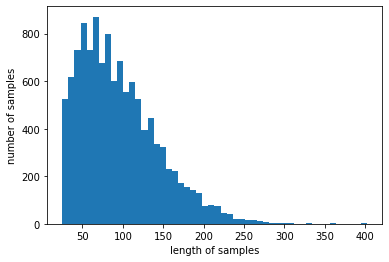

In [17]:
# 문장의 길이 구하기
import matplotlib.pyplot as plt
print('대화의 최대 길이 :',max(len(l) for l in train_utterance))
print('대화의 평균 길이 :',sum(map(len, train_utterance))/len(train_utterance))
plt.hist([len(s) for s in train_utterance], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
# padding의 max length 설정
MAX_LEN = 200

In [19]:
# 문장을 합친 경우, segment 정보 반영
def segment_funct(sentence):
  segment_id = []  
  lastidxsep = len(sentence) - 1 - sentence[::-1].index('[SEP]')
  idxcls = sentence.index('[CLS]')
  idxsep = sentence.index('[SEP]')
  #segment_id = [0] * (idxsep - idxcls +1) + [1] * ( MAX_LEN - idxsep-1) 
  if (lastidxsep == idxsep):
    segment_id = [0] * (idxsep - idxcls +1)
  else:  
    segment_id = [0] * (idxsep - idxcls +1) + [1] * ( lastidxsep - idxsep) 
  return segment_id

In [20]:
# 토큰 적용, 인덱스 변경, 패딩 함수
from keras.preprocessing.sequence import pad_sequences
from transformers import BertModel, BertTokenizer
def tokenize(dataset, segment_utterance):
  # 입력 토큰의 최대 시퀀스 길이
  tokenized_utterance = [ str(sentence) for sentence in dataset ]
  # token화 하기
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  tokenized_utterance = [tokenizer.tokenize(sent) for sent in tokenized_utterance]
  tokenized_segment_id = [segment_funct(sent) for sent in tokenized_utterance]
  # 인덱스로 변환하기 
  ids_utterance = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_utterance] 
  # 패딩 채우기
  ids_utterance = pad_sequences(ids_utterance, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  segment_id = pad_sequences(tokenized_segment_id, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  return ids_utterance, segment_id

In [21]:
# 토큰 적용, 인덱스 변경, 패딩 적용
segment_train = []
segment_dev = []
token_train_utterance, segment_train = tokenize(train_utterance, segment_train)
token_dev_utterance, segment_dev = tokenize(dev_utterance, segment_dev)

In [22]:
# 어텐션 마스크 
# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
def mask_func(masklist, targetdata):
  for seq in targetdata:
    seq_mask = [float(i>0) for i in seq]
    masklist.append(seq_mask)
  print(masklist[0])

In [23]:
# train과 dev data에 대해서 mask attention 적용
masks_train_utterance = []
masks_dev_utterance = []
mask_func(masks_train_utterance, token_train_utterance) 
mask_func(masks_dev_utterance, token_dev_utterance)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [24]:
# 데이터에 tensor 적용 함수
from keras.preprocessing.sequence import pad_sequences
from transformers import BertModel, BertTokenizer

class Dataset():
  def __init__(self, x, y, z, k):
    self.utterance = x
    self.emotion = y
    self.mask = z
    self.segment = k

  def __len__(self): 
    return len(self.utterance)

  def __getitem__(self, idx):
    input_tensor = torch.tensor(self.utterance[idx])
    labels_tensor = torch.tensor(i2e_dict[self.emotion[idx]])
    mask_tensor = torch.tensor(self.mask[idx])
    segment_tensor = torch.tensor(self.segment[idx])
    return input_tensor,labels_tensor, mask_tensor, segment_tensor

In [25]:
train_dataset = Dataset(token_train_utterance, train_emotion, masks_train_utterance, segment_train)
dev_dataset = Dataset(token_dev_utterance, dev_emotion, masks_dev_utterance, segment_dev)

In [26]:
# batch size 적용
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=8, shuffle=True)

**Test dataset**

In [27]:
# test dataset load
import csv
dialogs = []


with open('en_data.csv', newline='') as csvfile:
  dataread = csv.reader(csvfile)
  for i,row in enumerate(dataread):
    if i!=0:
      dialogs.append([row[0], row[1], row[2], row[3], row[4]])

# test data frame load
df_test = pd.DataFrame(dialogs, columns=['id','i_diaglog','i_utterance','speaker','utterance'])
test_utterance = df_test['utterance'].values.tolist()
test_speaker = df_test['speaker'].values.tolist()


In [28]:
test_utterance_copy = test_utterance.copy()
token_input(test_utterance, test_utterance_copy, test_speaker)

In [29]:
# token id, segment id 생성
segment_test = []
token_test_utterance, segment_test = tokenize(test_utterance, segment_test)

In [30]:
 # test mask attention 생성
masks_test_utterance = []
mask_func(masks_test_utterance, token_test_utterance) 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [31]:
# test 데이터를 텐서로 변환
test_inputs = torch.tensor(token_test_utterance)
test_masks = torch.tensor(masks_test_utterance)
test_segment = torch.tensor(segment_test)

##### **Hyper-parameters**

In [32]:
pretrained_weights = 'bert-base-uncased'
learning_rate = 2e-5 # 1e-5
n_epoch = 2

##### **Model**

In [33]:
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.bert_model = BertModel.from_pretrained(pretrained_weights)
    self.linear = torch.nn.Linear(768, len(i2e_dict)) # {'anger': 2,'disgust': 6,'fear': 0,'joy': 5,...}

  def forward(self, input_tensor, input_mask, segment_ids):
    hidden_tensor = self.bert_model(input_tensor,attention_mask=input_mask,token_type_ids=segment_ids)[0] # (bat, len, hid) -> case 1, case 2
    #hidden_tensor = self.bert_model(input_tensor,attention_mask=input_mask)[0] # (bat, len, hid) -> case 3
    hidden_tensor = hidden_tensor[:, 0, :] # (bat, hid)
    logit = self.linear(hidden_tensor)
    return logit

##### **Evaluation Metrics**

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score
# 모델 평가
def evaluate(true_list, pred_list):
  print(pred_list)
  print(true_list)
  precision = precision_score(true_list, pred_list, average=None)
  recall = recall_score(true_list, pred_list, average=None)
  micro_f1 = f1_score(true_list, pred_list, average='micro')

  # 출력 로짓과 라벨을 비교하여 정확도 계산
  eval_accuracy = flat_accuracy(pred_list, true_list)
  print('precision: ', ['%.4f' % v for v in precision])
  print('recall:\t\t', ['%.4f' % v for v in recall])
  print('micro_f1: %.6f' % micro_f1)
  print("Accuracy: {0:.2f}".format(eval_accuracy))

##### **Training**

In [35]:
# GPU 디바이스 이름 구함
import tensorflow as tf
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [36]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [37]:

"""
n_epoch = 2
for i_epoch in range(0, n_epoch):
  for batch_idx, batch_data in enumerate(train_dataloader): 
    x_train, y_train = samples
    print("x  : " + str(x_train))
    print("y  : " + str(y_train))   
"""

'\nn_epoch = 2\nfor i_epoch in range(0, n_epoch):\n  for batch_idx, batch_data in enumerate(train_dataloader): \n    x_train, y_train = samples\n    print("x  : " + str(x_train))\n    print("y  : " + str(y_train))   \n'

In [38]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = preds.flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [39]:
import time
import datetime
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
from tqdm import tqdm_notebook # tqdm_notebook 진행 표시바
import numpy as np
 
batch_size=8
model = Model() #정의된 모델 수행
model.cuda()
#criterion = torch.nn.CrossEntropyLoss() # LogSoftmax & NLLLoss, tf.nn.weighted_cross_entropy_with_logits
class_weight = torch.FloatTensor(weights).cuda()
criterion = torch.nn.CrossEntropyLoss(weight = class_weight)
optimizer = torch.optim.Adam(model.parameters(), learning_rate) #gradient descent 알고리즘 : Adam

for i_epoch in range(n_epoch + 1):
  print('i_epoch:', i_epoch)
  train_loss = 0 
  model.train()
  for batch_idx, batch_data in enumerate(train_dataloader): 

    # 배치를 GPU에 넣음
    batch_data = tuple(t.to(device) for t in batch_data)
    
    # 배치에서 데이터 추출
    b_input_ids, b_labels, b_input_mask, b_input_segment = batch_data

    # 배치에서 데이터 추출
    logit = model(b_input_ids, b_input_mask, b_input_segment)
    batch_loss = criterion(logit, b_labels)
    train_loss += batch_loss.item()
    
    model.zero_grad()
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  #시작 시간 설정
  t0 = time.time()

  # 평가모드로 변경
  bert_predicted = []
  all_logits = []
  model.eval()
  pred_list, true_list = np.array([]), np.array([])
  for batch_idx, batch_data in enumerate(dev_dataloader):
    # 배치를 GPU에 넣음
    batch_data = tuple(t1.to(device) for t1 in batch_data)
    # 배치에서 데이터 추출
    b_input_ids, b_labels, b_input_mask, b_input_segment = batch_data
    logit = model(b_input_ids, b_input_mask, b_input_segment)
    _, max_idx = torch.max(logit, dim=-1) # tensor
    
    numpy_max_idx = max_idx.detach().cpu().numpy() 
    b_labels = b_labels.detach().cpu().numpy() 

    pred_list = np.append(pred_list, numpy_max_idx)
    true_list = np.append(true_list, b_labels)
    
  evaluate(pred_list, true_list) # print results

i_epoch: 0
[3. 7. 3. ... 0. 0. 2.]
[2. 7. 3. ... 1. 0. 2.]
precision:  ['0.8059', '0.6643', '0.1571', '0.6588', '0.1912', '0.0625', '0.4658', '0.6620']
recall:		 ['0.4823', '0.4872', '0.3484', '0.1745', '0.3171', '0.0952', '0.3750', '0.8200']
micro_f1: 0.549204
Accuracy: 0.55
i_epoch: 1
[2. 7. 7. ... 7. 7. 7.]
[0. 3. 7. ... 7. 0. 2.]
precision:  ['0.7730', '0.6573', '0.0813', '0.5176', '0.4853', '0.3125', '0.5155', '0.6076']
recall:		 ['0.4896', '0.4736', '0.2651', '0.2418', '0.1209', '0.1000', '0.3689', '0.8310']
micro_f1: 0.513386
Accuracy: 0.51
i_epoch: 2
[1. 2. 2. ... 2. 2. 7.]
[7. 7. 2. ... 7. 2. 7.]
precision:  ['0.7434', '0.5070', '0.3013', '0.3529', '0.2500', '0.2188', '0.4037', '0.7133']
recall:		 ['0.5148', '0.5556', '0.3347', '0.2778', '0.3036', '0.0745', '0.4221', '0.7880']
micro_f1: 0.568379
Accuracy: 0.57


##### **Labeling**


In [40]:
# 문장 테스트
def test_sentences(inputs, masks, segment):
    
    # 평가모드로 변경
    model.eval()

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    b_input_segment = segment.to(device)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, b_input_mask, b_input_segment)
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    #logits = logits.detach().cpu().numpy()
    
    return logits

In [41]:
pred_label=[]
for i in range(len(test_inputs)):
  input_id = test_inputs[i].unsqueeze(0)
  input_mask =  test_masks[i].unsqueeze(0)
  input_segment =  test_segment[i].unsqueeze(0) 
  logits = test_sentences(input_id,input_mask, input_segment)
  #pred_flat = np.argmax(logits).flatten()
  _, max_idx = torch.max(logits, dim=-1) # tensor
  pred_emotion = max_idx.tolist()
  pred_flat = i2e_dict_change[pred_emotion]
  pred_label.append(pred_flat)

In [42]:
df = pd.DataFrame(df_test, columns=['id'])
df['Predicted'] = pred_label
print(df)

        id Predicted
0        0   neutral
1        1  surprise
2        2     anger
3        3   neutral
4        4     anger
...    ...       ...
1618  1618      fear
1619  1619       joy
1620  1620   neutral
1621  1621   neutral
1622  1622       joy

[1623 rows x 2 columns]


In [43]:
df.to_csv("test_friends.csv", sep=",",index=False)

##### **Proposal**

- There is a class imbalance problem. (Use weighted cross-entropy etc.)

- Our model takes a single sentence. (Make it grasp its context as well.)

- Our model does not consider speaker information. (Make it consider the info.)

- Batch size is set as 1. (Increase the batch size.)